In [1]:
from openbci_stream.acquisition import Cyton, OpenBCIConsumer
from openbci_stream.acquisition import CytonConstants as cons

from gcpds.utils.filters import GenericButterBand, notch60
from gcpds.utils.processing import welch, fourier

from matplotlib import pyplot as plt
import numpy as np
import time

from gcpds.utils.visualizations import plot_eeg

import logging
logging.getLogger().setLevel(logging.INFO)
logging.getLogger('kafka').setLevel(logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.ERROR)

def show(data):
    plt.figure(figsize=(10, 5), dpi=90)

    plt.subplot(121)
    [plt.plot(ch+(i*1e6)-ch.mean()) for (i, ch) in enumerate(data)]
    if len(data)>1:
        plt.yticks(np.arange(len(data))*1e6, [f'ch{ch+1}' for ch in range(len(data))])
    else:
        plt.ylabel('$\mu V$')
#     plt.xlim(0, 250)
    plt.xlabel('samples')

    plt.subplot(122)
    # w, Y = welch(data, fs=250, axis=1)
    w, Y = fourier(data, fs=250, axis=1)
    [plt.plot(w, y) for y in Y]
    plt.xlim(0, 90)
    plt.xlabel('Frequency [Hz]')
    
band_2737 = GenericButterBand(27, 37, fs=250)

def filter_impedance(v):
    v = notch60(v, fs=250)
    return band_2737(v, fs=250)

def get_z(v):
    rms = get_rms(v)
    z = (1e-6 * rms * np.sqrt(2) / 6e-9) - 2200
    if z < 0:
        return 0
    return z

INFO:root:Compiled `Butter` filter (27|37 Hz) for 250.00 Hz


In [14]:
# openbci = Cyton('serial', '/dev/ttyUSB1', capture_stream=True, daisy=False)
openbci = Cyton('wifi', '192.168.1.113', host='192.168.1.1', capture_stream=True, daisy=True)

openbci.command(cons.SAMPLE_RATE_250SPS)
openbci.command(cons.DEFAULT_CHANNELS_SETTINGS)
openbci.leadoff_impedance(range(1, 17), pchan=cons.TEST_SIGNAL_NOT_APPLIED, nchan=cons.TEST_SIGNAL_APPLIED)

openbci.stream(7)
data_raw = np.array(openbci.eeg_time_series)

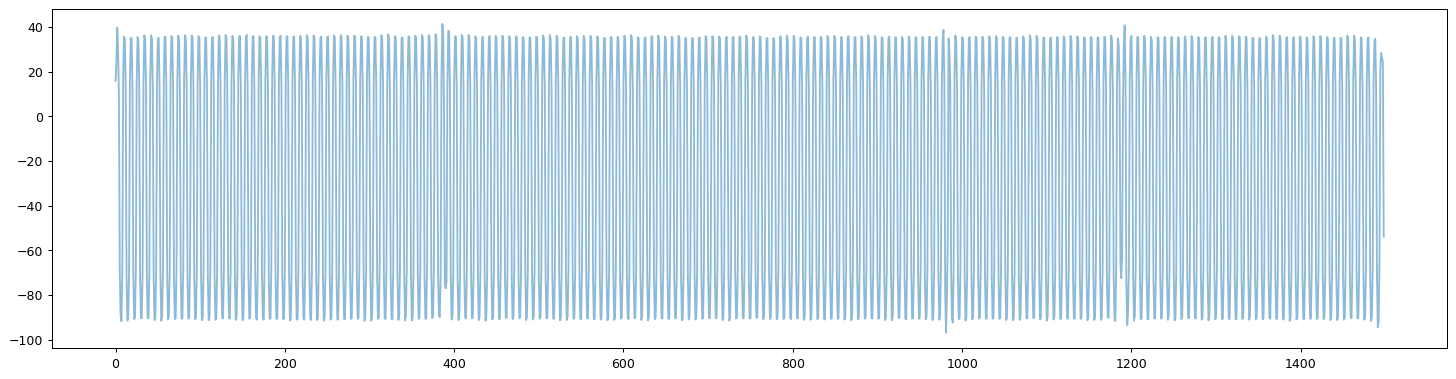

In [32]:
plt.figure(figsize=(20, 5), dpi=90)
# plt.plot(data_raw[0], '.', alpha=0.5)

plt.plot(notch60(data_raw[0], fs=250), '-', alpha=0.5)

# plt.plot(data_raw[1], '.', alpha=0.5)

# plt.ylim(-500, 500)
# plt.xlim(0, 250)